🟢 EDA BEFORE PREPROCESSING

Shape: (50, 5)

Data Types:
 Policy_ID          object
Policy_Text_EN     object
Policy_Text_FR     object
Policy_Text_ES     object
Summarized_Text    object
dtype: object

Missing Values:
 Policy_ID          0
Policy_Text_EN     0
Policy_Text_FR     0
Policy_Text_ES     0
Summarized_Text    0
dtype: int64


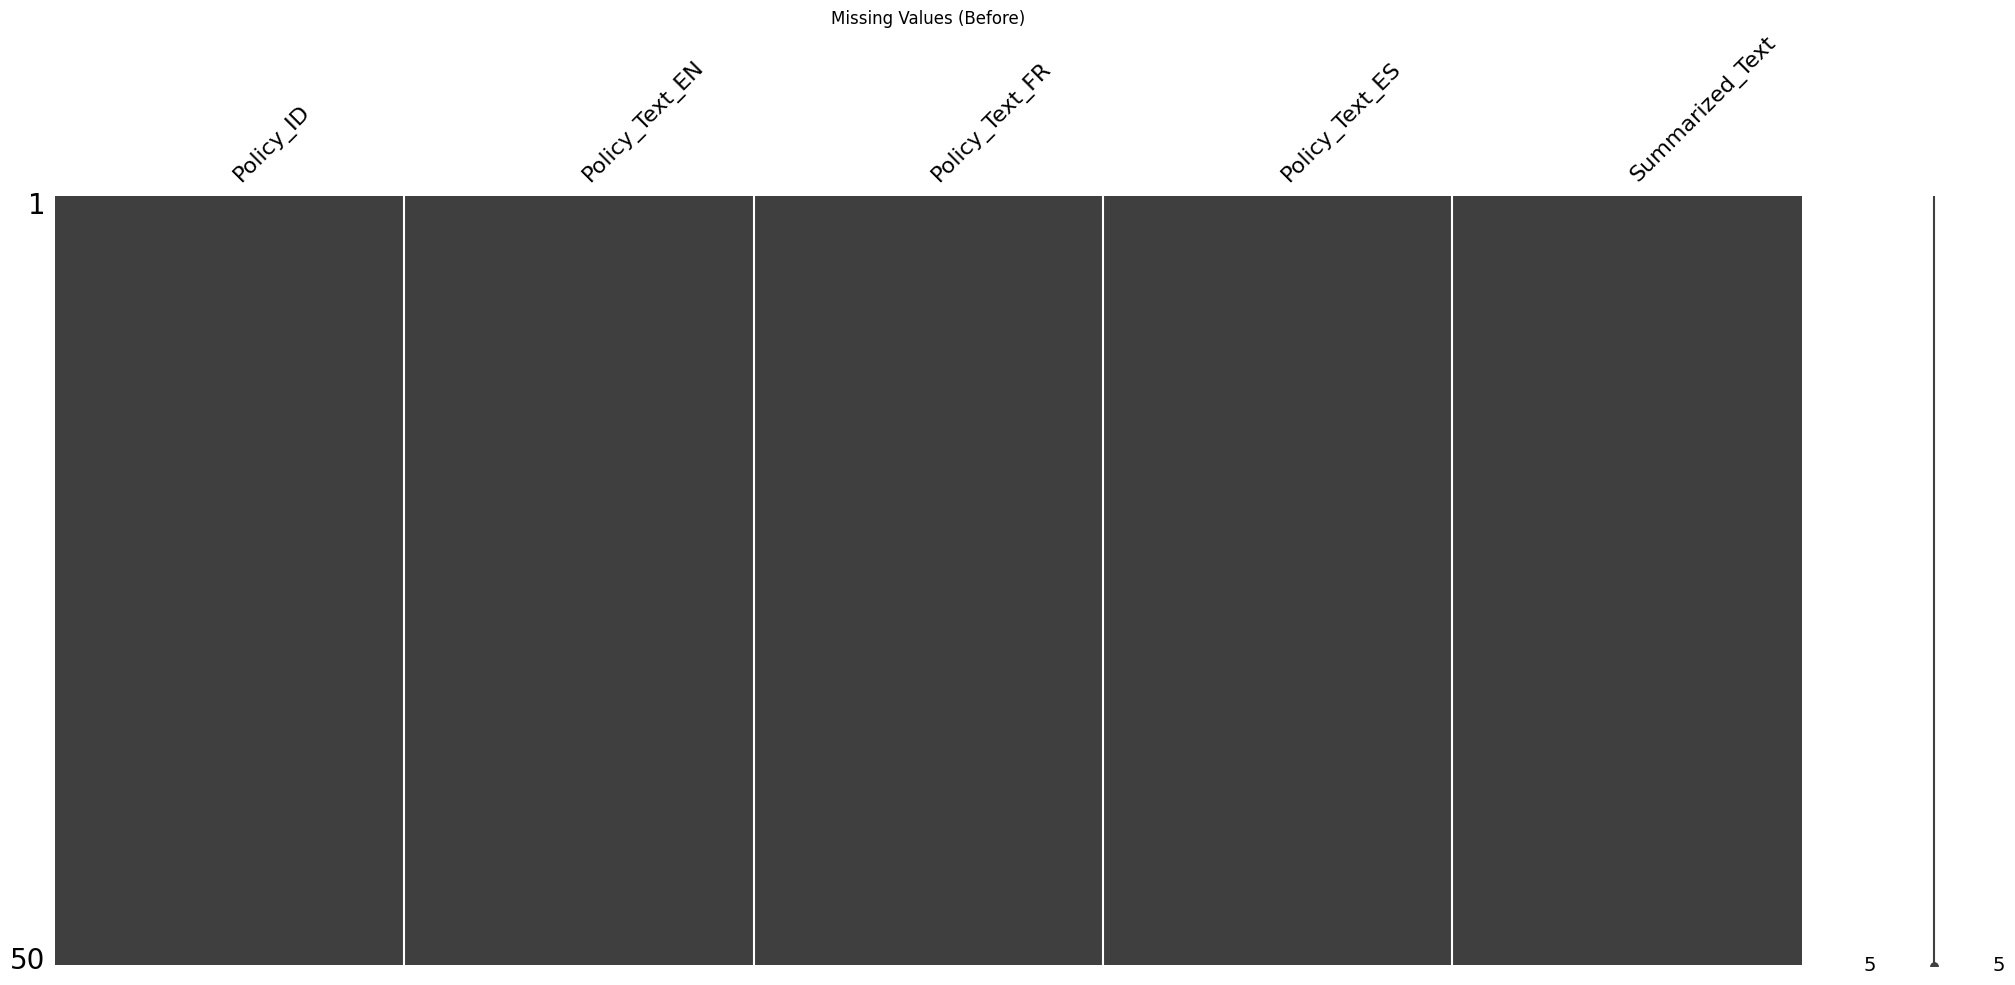

In [4]:
# 📦 Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder

# ✅ Define the EDA + Preprocessing Function
def run_eda_pipeline(df, target_column=None, encode_method='onehot', drop_first=True):
    df = df.copy()
    
    # ✅ Check if target column exists
    if target_column and target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in DataFrame. Available columns: {df.columns.tolist()}")

    print("🟢 EDA BEFORE PREPROCESSING\n")
    print("Shape:", df.shape)
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())

    # 📊 Missing Values Visual
    msno.matrix(df)
    plt.title("Missing Values (Before)")
    plt.show()

df = pd.read_csv("C:/Users/Administrator/Multilingual_Insurance_Policies_50.csv")
processed_df = run_eda_pipeline(df, target_column='Summarized_Text', encode_method='onehot')

In [1]:
# 📦 Required Libraries
import pandas as pd
import re

# 📁 Load Data
df = pd.read_csv("Multilingual_Insurance_Policies_50.csv")

# ✅ Dictionary for English contractions
contractions_dict = {
    "don't": "do not", "doesn't": "does not", "can't": "cannot", "won't": "will not",
    "i'm": "i am", "they're": "they are", "it's": "it is", "he's": "he is",
    "she's": "she is", "we're": "we are", "you're": "you are", "i've": "i have",
    "we've": "we have", "they've": "they have", "isn't": "is not", "aren't": "are not",
    "wasn't": "was not", "weren't": "were not", "i'll": "i will", "you'll": "you will",
    "he'll": "he will", "she'll": "she will", "we'll": "we will", "they'll": "they will",
    "there's": "there is", "that's": "that is", "what's": "what is", "who's": "who is"
}

# 🔁 Contraction expansion function
def expand_contractions(text):
    for contraction, full in contractions_dict.items():
        text = re.sub(rf"\b{contraction}\b", full, text)
    return text

# 🔧 English normalization
def normalize_english_text(text):
    text = text.lower()
    text = expand_contractions(text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# 🔧 French/Spanish normalization
def normalize_text_generic(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-ZÀ-ÿ0-9\s]", "", text)  # preserve accents
    text = re.sub(r"\s+", " ", text).strip()
    return text

# 🧹 Apply to English and Summary
df["Policy_Text_EN_Normalized"] = df["Policy_Text_EN"].apply(normalize_english_text)
df["Summarized_Text_Normalized"] = df["Summarized_Text"].apply(normalize_english_text)

# 🧹 Apply to French and Spanish
df["Policy_Text_FR_Normalized"] = df["Policy_Text_FR"].apply(normalize_text_generic)
df["Policy_Text_ES_Normalized"] = df["Policy_Text_ES"].apply(normalize_text_generic)

# 💾 Save normalized data
df.to_csv("Normalized_Multilingual_Insurance_Policies.csv", index=False)

# ✅ View sample output
print(df[[
    "Policy_Text_EN_Normalized", 
    "Policy_Text_FR_Normalized", 
    "Policy_Text_ES_Normalized", 
    "Summarized_Text_Normalized"
]].head())


                           Policy_Text_EN_Normalized  \
0  this policy covers damages to your vehicle due...   
1  comprehensive health insurance policy covering...   
2  home insurance protecting against fire theft a...   
3  travel insurance providing medical and trip ca...   
4  life insurance ensuring financial security for...   

                           Policy_Text_FR_Normalized  \
0  cette police couvre les dommages à votre véhic...   
1  police dassurance maladie complète couvrant lh...   
2  assurance habitation protégeant contre les inc...   
3  assurance voyage offrant une couverture médica...   
4  assurance vie garantissant la sécurité financi...   

                           Policy_Text_ES_Normalized  \
0  esta póliza cubre daños a su vehículo por acci...   
1  póliza de seguro de salud integral que cubre h...   
2  seguro de hogar que protege contra incendios r...   
3  seguro de viaje que proporciona cobertura médi...   
4  seguro de vida que garantiza la seguridad f

In [6]:
# 📦 Required Libraries
import pandas as pd
from transformers import (
    MarianMTModel, MarianTokenizer,
    T5Tokenizer, T5ForConditionalGeneration,
    Seq2SeqTrainer, Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq
)
from datasets import Dataset
from tqdm import tqdm
import torch

# 📁 Load Normalized Dataset
df = pd.read_csv("C:/Users/Administrator/Normalized_Multilingual_Insurance_Policies.csv")

# 🔧 Create fallback summary column if not available
df["Summary_EN"] = df["Policy_Text_EN_Normalized"].apply(lambda x: x[:150])

# ✅ Prepare Dataset for Fine-tuning
translation_dataset = pd.DataFrame({
    "translation_input": df["Policy_Text_EN_Normalized"],
    "translation_target": df["Policy_Text_FR"]
})

summarization_dataset = pd.DataFrame({
    "summary_input": "summarize: " + df["Policy_Text_EN_Normalized"],
    "summary_target": df["Summary_EN"]
})

# 🔄 Load Tokenizers & Models
translation_model_name = "Helsinki-NLP/opus-mt-en-fr"
translation_tokenizer = MarianTokenizer.from_pretrained(translation_model_name)
translation_model = MarianMTModel.from_pretrained(translation_model_name)

summarization_model_name = "t5-small"
summarization_tokenizer = T5Tokenizer.from_pretrained(summarization_model_name)
summarization_model = T5ForConditionalGeneration.from_pretrained(summarization_model_name)

# ✅ Dataset Conversion to Hugging Face Format
def tokenize_translation(example):
    model_inputs = translation_tokenizer(example["translation_input"], max_length=512, truncation=True, padding="max_length")
    with translation_tokenizer.as_target_tokenizer():
        labels = translation_tokenizer(example["translation_target"], max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

translation_hf = Dataset.from_pandas(translation_dataset)
translation_hf = translation_hf.map(tokenize_translation, batched=True)


def tokenize_summarization(example):
    model_inputs = summarization_tokenizer(example["summary_input"], max_length=512, truncation=True, padding="max_length")
    with summarization_tokenizer.as_target_tokenizer():
        labels = summarization_tokenizer(example["summary_target"], max_length=60, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

summarization_hf = Dataset.from_pandas(summarization_dataset)
summarization_hf = summarization_hf.map(tokenize_summarization, batched=True)

# 🏁 Training Arguments
translation_args = Seq2SeqTrainingArguments(
    output_dir="./finetuned_translation_model",
    evaluation_strategy="no",
    per_device_train_batch_size=4,
    save_total_limit=1,
    num_train_epochs=3,
    fp16=torch.cuda.is_available(),
    logging_steps=10
)

summarization_args = Seq2SeqTrainingArguments(
    output_dir="./finetuned_summarization_model",
    evaluation_strategy="no",
    per_device_train_batch_size=4,
    save_total_limit=1,
    num_train_epochs=3,
    fp16=torch.cuda.is_available(),
    logging_steps=10
)

# 🧠 Define Trainers
data_collator_translation = DataCollatorForSeq2Seq(tokenizer=translation_tokenizer, model=translation_model)
translation_trainer = Seq2SeqTrainer(
    model=translation_model,
    args=translation_args,
    train_dataset=translation_hf,
    tokenizer=translation_tokenizer,
    data_collator=data_collator_translation
)

data_collator_summarization = DataCollatorForSeq2Seq(tokenizer=summarization_tokenizer, model=summarization_model)
summarization_trainer = Seq2SeqTrainer(
    model=summarization_model,
    args=summarization_args,
    train_dataset=summarization_hf,
    tokenizer=summarization_tokenizer,
    data_collator=data_collator_summarization
)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [7]:
import pickle

# 📦 Wrap translation model and tokenizer
with open("translation_model.pkl", "wb") as f:
    pickle.dump({
        "model": translation_model,
        "tokenizer": translation_tokenizer
    }, f)

# 📦 Wrap summarization model and tokenizer
with open("summarization_model.pkl", "wb") as f:
    pickle.dump({
        "model": summarization_model,
        "tokenizer": summarization_tokenizer
    }, f)

print("✅ Models saved as .pkl files for Streamlit app usage.")


✅ Models saved as .pkl files for Streamlit app usage.
